In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, skew
from scipy.special import inv_boxcox
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone, RegressorMixin
from sklearn.linear_model import LassoCV, ElasticNetCV, HuberRegressor, Ridge, ElasticNet, Lasso
from sklearn.metrics import mean_squared_error, median_absolute_error
from hyperopt import tpe, fmin, Trials, hp, space_eval
import warnings


%matplotlib inline
sns.set_style('ticks')
sns.set_palette('muted')
warnings.filterwarnings('ignore')

## Load data

In [2]:
X = pd.read_pickle('dragon.p')
y = pd.read_pickle('low.p')
y = y.set_index('SMILES')
y = y[['YSI']]
X = X.reindex(y.index)
print('shape of features: ', X.shape)
print('shape of target: ', y.shape)

shape of features:  (297, 5270)
shape of target:  (297, 1)


In [3]:
X.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,CATS3D_10_LL,CATS3D_11_LL,CATS3D_12_LL,CATS3D_13_LL,CATS3D_14_LL,CATS3D_15_LL,CATS3D_16_LL,CATS3D_17_LL,CATS3D_18_LL,CATS3D_19_LL
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCCC,72.17,4.245,8.161,16.302,9.568,19.491,0.480,0.959,0.563,1.147,...,0,0,0,0,0,0,0,0,0,0
CCCCCC,86.20,4.310,9.688,19.185,11.330,22.906,0.484,0.959,0.566,1.145,...,0,0,0,0,0,0,0,0,0,0
CCCC(C)C,86.20,4.310,9.688,19.185,11.330,22.906,0.484,0.959,0.566,1.145,...,0,0,0,0,0,0,0,0,0,0
CCC(C)CC,86.20,4.310,9.688,19.185,11.330,22.906,0.484,0.959,0.566,1.145,...,0,0,0,0,0,0,0,0,0,0
CCC(C)(C)C,86.20,4.310,9.688,19.185,11.330,22.906,0.484,0.959,0.566,1.145,...,0,0,0,0,0,0,0,0,0,0


## Exploratory data analysis

This dataset contains only 297 samples, yet more than 5000 features. All the features are calculated by the [Dragon Molecular Descriptors Calculator](http://www.talete.mi.it/products/dragon_description.htm). Molecular descriptors in [Quantitative Structure–Activity Relationship (QSAR)](https://en.wikipedia.org/wiki/Quantitative_structure%E2%80%93activity_relationship) are synonyms of features in machine learning. Some features contains no useful information (all samples take the sasme value). These features should be removed, of course. Other features contains little information. For example, look at the *CATS3D_10_LL* column. This feature only takes two values: 0 and 2. Moreover, only one sample takes the value of 2 while all other samples take the value of 0. This kind of features contains little information and should thus be removed.

In [4]:
X['CATS3D_11_LL'].value_counts()

0    296
2      1
Name: CATS3D_11_LL, dtype: int64

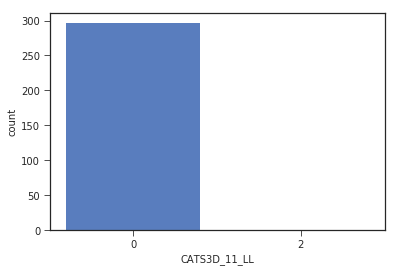

In [5]:
sns.countplot(x='CATS3D_11_LL', data=X)

These features containing little information usually are highly skewed because nearly all samples taken one value with a small number of exceptions. Therefore these featuers can be removed if their skewness exceeds some threshold.

In [6]:
X['CATS3D_11_LL'].skew()

17.233687939614089

The target value (YSI) is also a little skewed. It is usually desired to remove the skewness of the target. Box cox transformation is used here for this purpose.

In [7]:
y.skew()

YSI    0.719815
dtype: float64

## Splitting data into train and test set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

## Building the regression pipeline

Some of the steps in the machine learning pipeline (removing highly skewed features) are not avaialble is scikit-learn. Therefore I conctructed corresponding classes following scikit-learn APIs.

In [9]:
class removeSkew(BaseEstimator, TransformerMixin):
    '''Remove highly skewed features'''
    
    def __init__(self, skew_thres=10, unique_thres=3):
        self.skew_thres = skew_thres
        self.unique_thres = unique_thres
        
    def fit(self, X):
        df = pd.DataFrame(X)
        self.toDrop_ = []
        for col in df.columns:
            if abs(df[col].skew()) > 10 and len(df[col].unique())<3:
                self.toDrop_.append(col)
        return self
        
    def transform(self, X):
        df = pd.DataFrame(X)
        df = df.drop(self.toDrop_, axis=1)
        return df.values
    
    def fit_transform(self, X, y):
        self.fit(X)
        return self.transform(X)

Linear models are tried in favor of their simplicity. Since the dataset contains many more features than samples, regularization must be used. Two strategies of regularization are used here: [**Lasso**](https://en.wikipedia.org/wiki/Lasso_(statistics) (L1 regularization) and [**Elastic net regularization**](https://en.wikipedia.org/wiki/Elastic_net_regularization) (a combination of L1 and L2 regularizations). Note that the features should be standardized before fed to the model to avoid the situation where features of large scales dominate the model. Cross validation is used for hyperparameter tuning.

In [10]:
imputer = Imputer(strategy='mean', axis=0) # imputer automatically removes features with all missing values
sel = VarianceThreshold()                  # Remove features with the same values
deskew = removeSkew()                      # Remove highly skewed features
lasso = LassoCV(n_jobs=-1)
en = ElasticNetCV(max_iter=5000, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_jobs=-1)
scaler = StandardScaler()

In [11]:
lasso_pipe = Pipeline([('imputer', imputer), ('selection', sel), ('deskew', deskew), \
                 ('scaler', scaler), ('pred', lasso)])
en_pipe = Pipeline([('imputer', imputer), ('selection', sel), ('deskew', deskew), \
                 ('scaler', scaler), ('pred', en)])

In [12]:
lasso_pipe.fit(X_train, y_train.values.ravel())
en_pipe.fit(X_train, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('selection', VarianceThreshold(threshold=0.0)), ('deskew', removeSkew(skew_thres=10, unique_thres=3)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pred', ElasticNetCV(alphas...se,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0))])

In [13]:
lasso_train = lasso_pipe.predict(X_train)
lasso_test = lasso_pipe.predict(X_test)

en_train = en_pipe.predict(X_train)
en_test = en_pipe.predict(X_test)

Lasso scores:
Training R2, RMSE and MAE:     0.9541  6.1047  3.4093  
Test R2, RMSE and MAE:         0.9074  7.1773  3.4461  
Elastic net scores:
Training R2, RMSE and MAE:     0.9763  4.3809  2.1476  
Test R2, RMSE and MAE:         0.9141  6.9094  3.2617  


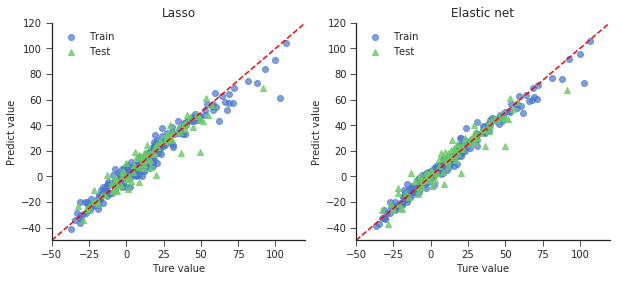

In [14]:
print('Lasso scores:')
print('Training R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(lasso_pipe.score(X_train, y_train.values.ravel()),
      np.sqrt(mean_squared_error(y_train, lasso_train)),
      median_absolute_error(y_train, lasso_train)))
print('Test R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(lasso_pipe.score(X_test, y_test.values.ravel()),
      np.sqrt(mean_squared_error(y_test, lasso_test)),
      median_absolute_error(y_test, lasso_test)))

print('Elastic net scores:')
print('Training R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(en_pipe.score(X_train, y_train.values.ravel()),
      np.sqrt(mean_squared_error(y_train, en_train)),
      median_absolute_error(y_train, en_train)))
print('Test R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(en_pipe.score(X_test, y_test.values.ravel()),
      np.sqrt(mean_squared_error(y_test, en_test)),
      median_absolute_error(y_test, en_test)))


fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.regplot(y_train.values, lasso_train, fit_reg=False, label='Train', scatter_kws={'alpha': 0.7}, ax=ax[0])
sns.regplot(y_test.values, lasso_test, fit_reg=False, label='Test', marker='^', ax=ax[0])
ax[0].axis([-50, 120, -50, 120])
ax[0].plot(ax[0].get_xlim(), ax[0].get_xlim(), color='red', linestyle='--')
ax[0].set_xlabel('Ture value')
ax[0].set_ylabel('Predict value')
ax[0].legend()
ax[0].set_title('Lasso')

ax[1].set_prop_cycle(None)
sns.regplot(y_train.values, en_train, fit_reg=False, label='Train', scatter_kws={'alpha': 0.7}, ax=ax[1])
sns.regplot(y_test.values, en_test, fit_reg=False, label='Test', marker='^', ax=ax[1])
ax[1].axis([-50, 120, -50, 120])
ax[1].plot(ax[1].get_xlim(), ax[1].get_xlim(), color='red', linestyle='--')
ax[1].set_xlabel('Ture value')
ax[1].set_ylabel('Predict value')
ax[1].legend()
ax[1].set_title('Elastic net')

sns.despine()

The scores indicate that elastic net is superior to Lasso in this case.

## Further improvement of model performance

There are three potential ways for model improvement:
* Use [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) which is more robust to outliers
* Further data processing
* Hyperparameter tuning

I tried both methods. However, using Huber loss tends to lead to overfitting and jeopardize model performance. Fortunately the second method does provide mild model improvement.

### Using Huber loss

In [15]:
huber = HuberRegressor(epsilon=100, alpha=1)
huber_pipe = Pipeline([('imputer', imputer), ('selection', sel), ('deskew', deskew), \
                 ('scaler', scaler), ('pred', huber)])
huber_pipe.fit(X_train, y_train.values.ravel())
huber_pipe.score(X_train, y_train.values.ravel())

0.99897652557841832

In [16]:
y4_train_pred = huber_pipe.predict(X_train)
y4_test_pred = huber_pipe.predict(X_test)
print('Training error: ', np.sqrt(mean_squared_error(y_train, y4_train_pred)),\
      median_absolute_error(y_train, y4_train_pred))
print('Test error: ', np.sqrt(mean_squared_error(y_test, y4_test_pred)),\
      median_absolute_error(y_test, y4_test_pred))

Training error:  0.911112405498 0.569938811735
Test error:  7.56172494303 4.47436947082


Using huber loss seems to lead to overfitting and jeopardize model performance.

### Further data processing
The target values are a little skewed.

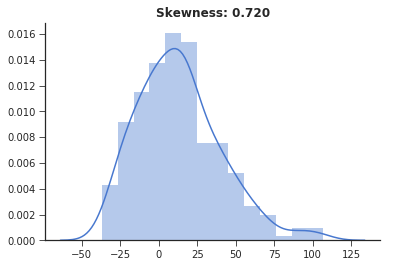

In [17]:
sns.distplot(y)
plt.gca().set_title('Skewness: {:.3f}'.format(y.skew()[0]), weight='bold')
sns.despine()

It is thus desirable to remove the skewness in the target. [**Box-Cox Transformation**]() is used for this purpose. Since Box-Cox transformation only works with positive values. The targets in the dataset should first be translated so that all the values become positive. Box-Cox transformation is then applied to the translated targets. I wrote another class to implement this functionality with scikit-learn APIs.

In [18]:
# Box-Cox transformation of target
class predictor(BaseEstimator, RegressorMixin, TransformerMixin):
    
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y):
        '''Box-Cox transformation of target''' 
        try:
            self.ymin_ = -80
        except:
            self.ymin_ = y.min()
        self.ty_, self.lambda_ = boxcox(y - self.ymin_ + 1)
        temp = inv_boxcox(self.ty_, self.lambda_) + self.ymin_ - 1 - y
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, self.ty_)
        return self
    
    def predict(self, X):
        self.yp = self.estimator_.predict(X)
        y = inv_boxcox(self.yp, self.lambda_) + self.ymin_ - 1
        return y

In [19]:
pred_lasso = predictor(lasso)
pred_en = predictor(en)
lasso_bc_pipe = Pipeline([('imputer', imputer), ('selection', sel), ('deskew', deskew), \
                 ('scaler', scaler), ('pred', pred_lasso)])
en_bc_pipe = Pipeline([('imputer', imputer), ('selection', sel), ('deskew', deskew), \
                 ('scaler', scaler), ('pred', pred_en)])

In [20]:
lasso_bc_pipe.fit(X_train, y_train.values.ravel())
en_bc_pipe.fit(X_train, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('selection', VarianceThreshold(threshold=0.0)), ('deskew', removeSkew(skew_thres=10, unique_thres=3)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pred', predictor(estimator...e,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)))])

In [21]:
lasso_bc_train = lasso_bc_pipe.predict(X_train)
lasso_bc_test = lasso_bc_pipe.predict(X_test)

en_bc_train = en_bc_pipe.predict(X_train)
en_bc_test = en_bc_pipe.predict(X_test)

Lasso scores:
Training R2, RMSE and MAE:     0.9601  5.6891  2.9621  
Test R2, RMSE and MAE:         0.9072  7.1824  2.9515  
Elastic net scores:
Training R2, RMSE and MAE:     0.9581  5.8331  3.0135  
Test R2, RMSE and MAE:         0.9060  7.2288  3.0002  


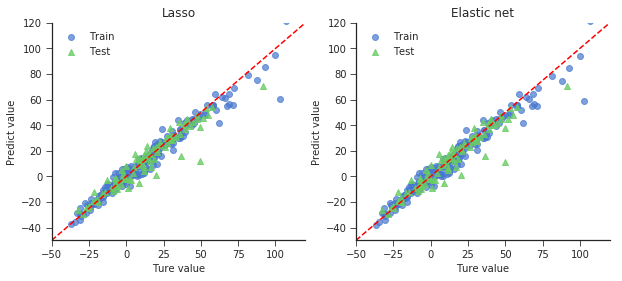

In [22]:
print('Lasso scores:')
print('Training R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(lasso_bc_pipe.score(X_train, y_train.values.ravel()),
      np.sqrt(mean_squared_error(y_train, lasso_bc_train)),
      median_absolute_error(y_train, lasso_bc_train)))
print('Test R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(lasso_bc_pipe.score(X_test, y_test.values.ravel()),
      np.sqrt(mean_squared_error(y_test, lasso_bc_test)),
      median_absolute_error(y_test, lasso_bc_test)))

print('Elastic net scores:')
print('Training R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(en_bc_pipe.score(X_train, y_train.values.ravel()),
      np.sqrt(mean_squared_error(y_train, en_bc_train)),
      median_absolute_error(y_train, en_bc_train)))
print('Test R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(en_bc_pipe.score(X_test, y_test.values.ravel()),
      np.sqrt(mean_squared_error(y_test, en_bc_test)),
      median_absolute_error(y_test, en_bc_test)))


fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.regplot(y_train.values, lasso_bc_train, fit_reg=False, label='Train', scatter_kws={'alpha': 0.7}, ax=ax[0])
sns.regplot(y_test.values, lasso_bc_test, fit_reg=False, label='Test', marker='^', ax=ax[0])
ax[0].axis([-50, 120, -50, 120])
ax[0].plot(ax[0].get_xlim(), ax[0].get_xlim(), color='red', linestyle='--')
ax[0].set_xlabel('Ture value')
ax[0].set_ylabel('Predict value')
ax[0].legend()
ax[0].set_title('Lasso')

ax[1].set_prop_cycle(None)
sns.regplot(y_train.values, en_bc_train, fit_reg=False, label='Train', scatter_kws={'alpha': 0.7}, ax=ax[1])
sns.regplot(y_test.values, en_bc_test, fit_reg=False, label='Test', marker='^', ax=ax[1])
ax[1].axis([-50, 120, -50, 120])
ax[1].plot(ax[1].get_xlim(), ax[1].get_xlim(), color='red', linestyle='--')
ax[1].set_xlabel('Ture value')
ax[1].set_ylabel('Predict value')
ax[1].legend()
ax[1].set_title('Elastic net')

sns.despine()

### Hyperparameter tuning by Bayesian optimization
Here I used [hyperopt](http://hyperopt.github.io/hyperopt/) for hyperparameter tuning. It requires a "objective function" to minimize. I used MAE as the metric for evaluating model performance because this is the metric utilized by the original paper.

Three hyperparameters are considered:
* Type of scaler
* Type of regularization (L1, L2, or combination of L1 and L2 regularizations)
* Strength of regularization

**Without Box-Cox transformation of the target**

In [23]:
space = {}
space['scaler'] = hp.choice('scaler', [StandardScaler(), RobustScaler(), MaxAbsScaler(), MinMaxScaler()])
space['pred'] = hp.choice('pred', [
            {
                'type': 'lasso',
                'pred__alpha': hp.loguniform('pred__alpha1', -3*np.log(10), 4*np.log(10))
            },
            {
                'type': 'ridge',
                'pred__alpha': hp.loguniform('pred__alpha2', -3*np.log(10), 4*np.log(10))
            },
            {
                'type': 'elastic', 
                'pred__alpha': hp.loguniform('pred__alpha3', -3*np.log(10), 4*np.log(10)),
                'pred__l1_ratio': hp.uniform('l1_ratio', 0,1)
            }
])

In [24]:
def objective(params):
    en_bc_pipe.set_params(scaler=params['scaler'])
    t = params['pred']['type']
    del params['pred']['type']
    if t=='lasso':
        en_bc_pipe.set_params(pred=Lasso())
    if t == 'ridge':
        en_bc_pipe.set_params(pred=Ridge())
    if t == 'elastic':
        en_bc_pipe.set_params(pred=ElasticNet())
    en_bc_pipe.set_params(**params['pred'])
    shuffle = KFold(n_splits=5, shuffle=True)
    score = cross_val_score(en_bc_pipe, X_train, y_train, cv=shuffle,
                            scoring='neg_median_absolute_error', n_jobs=-1).mean()
    return -score

In [25]:
r = np.random.RandomState(23)
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=500, trials=trials, rstate=r)

In [26]:
opt = space_eval(space, best)
opt

{'pred': {'pred__alpha': 0.014357682419182689,
  'pred__l1_ratio': 0.4487023312433226,
  'type': 'elastic'},
 'scaler': MaxAbsScaler(copy=True)}

In [27]:
if opt['pred']['type'] == 'elastic':
    opt_pipe = Pipeline([
        ('imputer', imputer), ('selection', sel), ('deskew', deskew),
        ('scaler', opt['scaler']), 
        ('pred', ElasticNet(alpha=opt['pred']['pred__alpha'], l1_ratio=opt['pred']['pred__l1_ratio']))
    ])
elif opt['pred']['type'] == 'ridge':
    opt_pipe = Pipeline([
        ('imputer', imputer), ('selection', sel), ('deskew', deskew),
        ('scaler', opt['scaler']), 
        ('pred', Ridge(alpha=opt['pred']['pred__alpha']))
    ])
else:
    opt_pipe = Pipeline([
        ('imputer', imputer), ('selection', sel), ('deskew', deskew),
        ('scaler', opt['scaler']), 
        ('pred', Lasso(alpha=opt['pred']['pred__alpha']))
    ])

In [28]:
opt_pipe.fit(X_train, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('selection', VarianceThreshold(threshold=0.0)), ('deskew', removeSkew(skew_thres=10, unique_thres=3)), ('scaler', MaxAbsScaler(copy=True)), ('pred', ElasticNet(alpha=0.014357682419182689, copy_X=True, ...alse, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))])

In [29]:
opt_train = opt_pipe.predict(X_train)
opt_test = opt_pipe.predict(X_test)

Lasso scores after hyperparameter tuning:
Training R2, RMSE and MAE:     0.9890  2.9813  1.4842  
Test R2, RMSE and MAE:         0.9119  7.0012  3.3685  


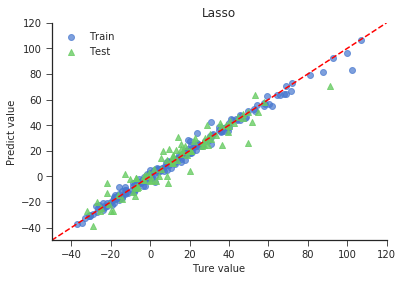

In [30]:
print('Lasso scores after hyperparameter tuning:')
print('Training R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(opt_pipe.score(X_train, y_train.values.ravel()),
      np.sqrt(mean_squared_error(y_train, opt_train)),
      median_absolute_error(y_train, opt_train)))
print('Test R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(opt_pipe.score(X_test, y_test.values.ravel()),
      np.sqrt(mean_squared_error(y_test, opt_test)),
      median_absolute_error(y_test, opt_test)))


fig, ax = plt.subplots()
sns.regplot(y_train.values, opt_train, fit_reg=False, label='Train', scatter_kws={'alpha': 0.7}, ax=ax)
sns.regplot(y_test.values, opt_test, fit_reg=False, label='Test', marker='^', ax=ax)
ax.axis([-50, 120, -50, 120])
ax.plot(ax.get_xlim(), ax.get_xlim(), color='red', linestyle='--')
ax.set_xlabel('Ture value')
ax.set_ylabel('Predict value')
ax.legend()
ax.set_title('Lasso')

sns.despine()
plt.show()

**With Box-Cox transformation of the target**

In [31]:
space2 = {}
space2['scaler'] = hp.choice('scaler', [StandardScaler(), RobustScaler(), MaxAbsScaler(), MinMaxScaler()])
space2['pred'] = hp.choice('pred', [
            {
                'type': 'lasso',
                'alpha': hp.loguniform('alpha1', -3*np.log(10), 4*np.log(10))
            },
            {
                'type': 'ridge',
                'alpha': hp.loguniform('alpha2', -3*np.log(10), 4*np.log(10))
            },
            {
                'type': 'elastic', 
                'alpha': hp.loguniform('alpha3', -3*np.log(10), 4*np.log(10)),
                'l1_ratio': hp.uniform('l1_ratio', 0,1)
            }
])

In [32]:
def objective2(params):
    en_bc_pipe.set_params(scaler=params['scaler'])
    t = params['pred']['type']
    del params['pred']['type']
    if t=='lasso':
        en_bc_pipe.set_params(pred=predictor(Lasso(**params['pred'])))
    if t == 'ridge':
        en_bc_pipe.set_params(pred=predictor(Ridge(**params['pred'])))
    if t == 'elastic':
        en_bc_pipe.set_params(pred=predictor(ElasticNet(**params['pred'])))
#     en_bc_pipe.set_params(**params['pred'])
    shuffle = KFold(n_splits=5, shuffle=True)
    score = cross_val_score(en_bc_pipe, X_train, y_train, cv=shuffle,
                            scoring='neg_median_absolute_error', n_jobs=-1).mean()
    return -score

In [33]:
trials = Trials()
best2 = fmin(objective2, space2, algo=tpe.suggest, max_evals=500, trials=trials, rstate=r)

In [34]:
opt2 = space_eval(space2, best2)
opt2

{'pred': {'alpha': 4.674811358887592, 'type': 'ridge'},
 'scaler': MaxAbsScaler(copy=True)}

In [36]:
if opt2['pred']['type'] == 'elastic':
    opt2_pipe = Pipeline([
        ('imputer', imputer), ('selection', sel), ('deskew', deskew),
        ('scaler', opt2['scaler']), 
        ('pred', ElasticNet(alpha=opt2['pred']['alpha'], l1_ratio=opt2['pred']['l1_ratio']))
    ])
elif opt2['pred']['type'] == 'ridge':
    opt2_pipe = Pipeline([
        ('imputer', imputer), ('selection', sel), ('deskew', deskew),
        ('scaler', opt2['scaler']), 
        ('pred', Ridge(alpha=opt2['pred']['alpha']))
    ])
else:
    opt2_pipe = Pipeline([
        ('imputer', imputer), ('selection', sel), ('deskew', deskew),
        ('scaler', opt2['scaler']), 
        ('pred', Lasso(alpha=opt2['pred']['alpha']))
    ])

In [37]:
opt2_pipe.fit(X_train, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('selection', VarianceThreshold(threshold=0.0)), ('deskew', removeSkew(skew_thres=10, unique_thres=3)), ('scaler', MaxAbsScaler(copy=True)), ('pred', Ridge(alpha=4.674811358887592, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [38]:
opt2_train = opt2_pipe.predict(X_train)
opt2_test = opt2_pipe.predict(X_test)

Ridge Regression scores after hyperparameter tuning:
Training R2, RMSE and MAE:     0.9859  3.3850  1.6572  
Test R2, RMSE and MAE:         0.9078  7.1585  3.3489  


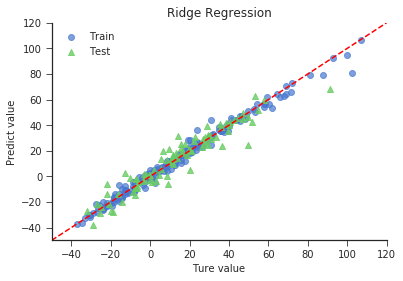

In [39]:
print('Ridge Regression scores after hyperparameter tuning:')
print('Training R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(opt2_pipe.score(X_train, y_train.values.ravel()),
      np.sqrt(mean_squared_error(y_train, opt2_train)),
      median_absolute_error(y_train, opt2_train)))
print('Test R2, RMSE and MAE: '.ljust(30),
      '{:<8.4f}{:<8.4f}{:<8.4f}'.format(opt2_pipe.score(X_test, y_test.values.ravel()),
      np.sqrt(mean_squared_error(y_test, opt2_test)),
      median_absolute_error(y_test, opt2_test)))


fig, ax = plt.subplots()
sns.regplot(y_train.values, opt2_train, fit_reg=False, label='Train', scatter_kws={'alpha': 0.7}, ax=ax)
sns.regplot(y_test.values, opt2_test, fit_reg=False, label='Test', marker='^', ax=ax)
ax.axis([-50, 120, -50, 120])
ax.plot(ax.get_xlim(), ax.get_xlim(), color='red', linestyle='--')
ax.set_xlabel('Ture value')
ax.set_ylabel('Predict value')
ax.legend()
ax.set_title('Ridge Regression')

sns.despine()

Overall Lasso and elastic net with Box-Cox transformation of the target gives the lowest test MAE (2.95 and 3.00 respectively). Surprisingly this simple model achieves very good results that is comparable to the fully connect neural networks employed by the original paper (test MAE 3.08). Due to different ways of splitting the original dataset the results may not be perfectly comparable. However, this analysis shows that apporiate preprocessing of the data can improve the model performance and achieve good results with simple models. The time required for model training is drastically reduced in this way.